In [ ]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import ToTensor

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
parasitized_data = os.listdir("/content/drive/MyDrive/neiron lab/lab2/cell_images/Parasitized")
uninfected_data = os.listdir("/content/drive/MyDrive/neiron lab/lab2/cell_images/Uninfected")

In [ ]:
def show_img(path, img_data, count, title_name):
  plt.figure(figsize = (15, 15))
  for i in range(4):
    plt.subplot(1, 4, i+1)
    img = Image.open(path + img_data[i + count])
    plt.imshow(img)
    plt.title(title_name)
    plt.tight_layout
  plt.show()

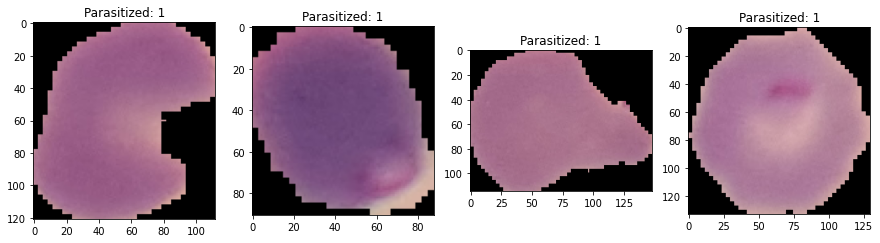

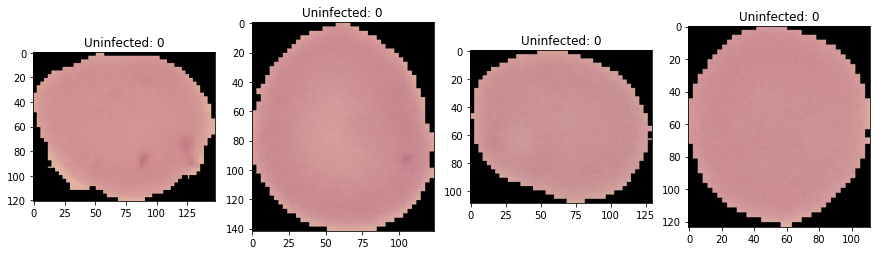

In [ ]:
show_img("/content/drive/MyDrive/neiron lab/lab2/cell_images/Parasitized/", parasitized_data, 0, "Parasitized: 1")
show_img("/content/drive/MyDrive/neiron lab/lab2/cell_images/Uninfected/", uninfected_data, 1, "Uninfected: 0")

In [ ]:
def add_img(data, labels, ds, count, images, path):
  for img in images:
  if count == 2000:
    count = 0
    break
  img_read = Image.open(path + img)
  img = img_read.convert('L')
  img_resize = img.resize((28, 28), Image.ANTIALIAS)
  img_resize = np.array(img_resize, dtype=np.float32)
  img_resize = img_resize/255.0

  t_img = torch.from_numpy(img_resize)
  data.append(t_img)
  labels.append(torch.tensor(1))
  ds.append((t_img,torch.tensor(1)))
  count+=1
  if count % 100 == 0:
    print(count)
  return data, labels, ds, count

In [ ]:
data = []
labels = []
ds = []
count = 0

data, labels, ds, count = add_img(data, labels, ds, count, parasitized_data, "/content/drive/MyDrive/neiron lab/lab2/cell_images/Parasitized/")
data, labels, ds, count = add_img(data, labels, ds, count, uninfected_data, "/content/drive/MyDrive/neiron lab/lab2/cell_images/Uninfected/")

print(data[0].shape)

In [ ]:
print(data[0].shape)

torch.Size([28, 28])


In [ ]:
len(ds)

4000

In [ ]:
batch_size = 32

In [ ]:
import random
ds = random.sample(ds, len(ds))

train_loader = torch.utils.data.DataLoader(ds[:3400],
                                         batch_size = batch_size,
                                         num_workers = 1,
                                         drop_last = True)

test_loader = torch.utils.data.DataLoader(ds[3400:], batch_size = batch_size, num_workers = 1, drop_last = False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, Win, W1, W2, Wout):
        super(MLP, self).__init__()
        self.Win = Win
        self.layer1 = nn.Linear(Win, W1)
        self.layer2 = nn.Linear(W1, W2)
        self.layerout = nn.Linear(W2, Wout)

    def forward(self, x):
        x = x.view(-1, self.Win)
        lr1 = nn.functional.relu(self.layer1(x))
        lr2 = nn.functional.relu(self.layer2(lr1))
        lrout = nn.functional.sigmoid(self.layerout(lr2))
        return lrout

In [ ]:
def train(network, learning_rate, epochs):
    losses, accuracies = dict(train = []), dict(train = [])
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), learning_rate)

    for epoch in range(epochs):
        network.train()
        tr_loss = 0.0
        tr_corr = 0
        n_samples = 0
        for data, label in train_loader:
            n_samples += data.shape[0]
            optimizer.zero_grad()
            output = network(data)

            _, preds = torch.max(output, 1)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item() * data.size(0)
            tr_corr += torch.sum(preds == label.data)

        train_loss = tr_loss / n_samples
        train_acc = tr_corr.double() / n_samples
        losses['train'].append(train_loss)
        accuracies['train'].append(train_acc)

        network.eval()

        if epoch % 10 == 0:
          print("Epoch {0} loss {1} acc {2}".format(epoch, train_loss, train_acc))

    return network, losses, accuracies

In [ ]:
model = MLP(784, 7000, 100, 2)
model, losses, accuracies = train(model, 0.1, 101)

Epoch 0 loss 0.6920786230069287 acc 0.5053066037735849
Epoch 10 loss 0.6537189804158121 acc 0.6191037735849056
Epoch 20 loss 0.6180657831565389 acc 0.6709905660377359
Epoch 30 loss 0.5933899041616691 acc 0.7119693396226415
Epoch 40 loss 0.5685108964735607 acc 0.738502358490566
Epoch 50 loss 0.5619422037084147 acc 0.7405660377358491
Epoch 60 loss 0.5408989871447941 acc 0.7682783018867925
Epoch 70 loss 0.5418848083266672 acc 0.7553066037735849
Epoch 80 loss 0.515634575823568 acc 0.7874410377358491
Epoch 90 loss 0.5134625668233296 acc 0.7954009433962265
Epoch 100 loss 0.5103800513272015 acc 0.7956957547169812


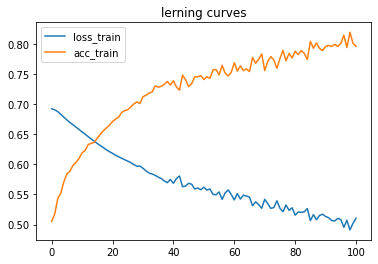

In [ ]:
plt.title("lerning curves")
plt.plot(losses["train"], label = "loss_train")
plt.plot(accuracies["train"], label = "acc_train")
plt.legend()
plt.show()